In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim



In [ ]:
df=pd.read_csv('cleaned_yellow_d1.csv')
df.head()

,Unnamed: 0,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,trip_duration_minutes,pickup_hour,pickup_day,pickup_month
0,1,166,75,1.0,1.32,8.60,1.0,0.5,0.00,0.00,11.10,2.0,1.0,0.0,0.0,5.883333,0,Wednesday,1
1,2,171,73,1.0,0.41,25.55,0.0,0.0,0.00,0.00,26.55,2.0,2.0,0.0,0.0,1.866667,0,Wednesday,1
2,3,74,223,1.0,4.12,21.20,1.0,0.5,6.13,6.94,36.77,1.0,1.0,0.0,0.0,15.466667,0,Wednesday,1
3,7,166,244,1.0,2.09,13.50,1.0,0.5,0.00,0.00,16.00,2.0,1.0,0.0,0.0,11.150000,0,Wednesday,1
4,8,166,151,1.0,0.95,7.90,1.0,0.5,2.08,0.00,12.48,1.0,1.0,0.0,0.0,6.533333,0,Wednesday,1


In [3]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,trip_duration_minutes,pickup_hour,pickup_day,pickup_month
0,166,75,1.0,1.32,8.60,1.0,0.5,0.00,0.00,11.10,2.0,1.0,0.0,0.0,5.883333,0,Wednesday,1
1,171,73,1.0,0.41,25.55,0.0,0.0,0.00,0.00,26.55,2.0,2.0,0.0,0.0,1.866667,0,Wednesday,1
2,74,223,1.0,4.12,21.20,1.0,0.5,6.13,6.94,36.77,1.0,1.0,0.0,0.0,15.466667,0,Wednesday,1
3,166,244,1.0,2.09,13.50,1.0,0.5,0.00,0.00,16.00,2.0,1.0,0.0,0.0,11.150000,0,Wednesday,1
4,166,151,1.0,0.95,7.90,1.0,0.5,2.08,0.00,12.48,1.0,1.0,0.0,0.0,6.533333,0,Wednesday,1


In [4]:
print(df.columns)

Index(['PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'cbd_congestion_fee', 'trip_duration_minutes', 'pickup_hour',
       'pickup_day', 'pickup_month'],
      dtype='object')


In [5]:
columns = ['PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'cbd_congestion_fee', 'trip_duration_minutes', 'pickup_hour',
       'pickup_day', 'pickup_month']
X = df[columns]
y = df['fare_amount']
print(len(columns))


17


In [6]:
# Check data shapes and prepare for PyTorch
print("=== DATA PREPARATION ===")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X columns: {list(X.columns)}")
print(f"Target variable: fare_amount")

# Check for any missing values
print(f"\nMissing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

# Basic statistics
print(f"\nTarget statistics:")
print(f"y mean: {y.mean():.2f}")
print(f"y std: {y.std():.2f}")
print(f"y min: {y.min():.2f}")
print(f"y max: {y.max():.2f}")

=== DATA PREPARATION ===
X shape: (35408, 17)
y shape: (35408,)
X columns: ['PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge', 'cbd_congestion_fee', 'trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_month']
Target variable: fare_amount

Missing values in X: 0
Missing values in y: 0

Target statistics:
y mean: 13.02
y std: 5.27
y min: 0.00
y max: 28.54


### Custom Dataset Class for Taxi Fare Prediction



In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class TaxiFareDataset(Dataset):
    """
    Custom Dataset class for taxi fare prediction
    """
    def __init__(self, features, targets, transform=True):
        """
        Args:
            features (pandas.DataFrame): Input features (X)
            targets (pandas.Series): Target values (y)
            transform (bool): Whether to apply standardization
        """
        self.features = features.copy()
        self.targets = targets.copy()
        
        # Handle categorical columns (convert to numeric if needed)
        categorical_cols = ['pickup_day']
        if 'pickup_day' in self.features.columns:
            # Convert day names to numbers
            day_mapping = {
                'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
                'Friday': 4, 'Saturday': 5, 'Sunday': 6
            }
            self.features['pickup_day'] = self.features['pickup_day'].map(day_mapping)
        
        # Convert to numpy arrays
        self.features = self.features.values.astype(np.float32)
        self.targets = self.targets.values.astype(np.float32)
        
        # Apply standardization if requested
        if transform:
            self.scaler = StandardScaler()
            self.features = self.scaler.fit_transform(self.features)
        
        # Convert to tensors
        self.x_data = torch.tensor(self.features, dtype=torch.float32)
        self.y_data = torch.tensor(self.targets, dtype=torch.float32)
        
        print(f"Dataset created with {len(self)} samples")
        print(f"Feature shape: {self.x_data.shape}")
        print(f"Target shape: {self.y_data.shape}")

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Create train-test split
print("=== SPLITTING DATA ===")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Create datasets
train_dataset = TaxiFareDataset(X_train, y_train, transform=True)
test_dataset = TaxiFareDataset(X_test, y_test, transform=True)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")

=== SPLITTING DATA ===
Training set: 28326 samples
Test set: 7082 samples
Dataset created with 28326 samples
Feature shape: torch.Size([28326, 17])
Target shape: torch.Size([28326])
Dataset created with 7082 samples
Feature shape: torch.Size([7082, 17])
Target shape: torch.Size([7082])

DataLoaders created:
Train batches: 443
Test batches: 111
Batch size: 64


### Neural Network Model for Taxi Fare Prediction


In [8]:
class TaxiFareModel(nn.Module):
    """
    Deep Neural Network for taxi fare prediction
    """
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.2):
        super(TaxiFareModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Output layer (single neuron for regression)
        layers.append(nn.Linear(prev_size, 1))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x).squeeze()

# Initialize model
input_size = X.shape[1]  # Number of features
model = TaxiFareModel(input_size=input_size)

print(f"=== MODEL ARCHITECTURE ===")
print(f"Input size: {input_size} features")
print(f"Model: {model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10)

print(f"\nOptimizer: Adam")
print(f"Loss function: MSE")
print(f"Learning rate: 0.001")

=== MODEL ARCHITECTURE ===
Input size: 17 features
Model: TaxiFareModel(
  (model): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total parameters: 13121

Optimizer: Adam
Loss function: MSE
Learning rate: 0.001


### Training and Evaluation Functions


In [10]:
def train_model(model, train_loader, criterion, optimizer, device='cpu'):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    return total_loss / num_batches

def evaluate_model(model, test_loader, criterion, device='cpu'):
    """Evaluate the model"""
    model.eval()
    total_loss = 0.0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    
    # Calculate additional metrics
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    # R² score
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return avg_loss, mse, rmse, mae, r2, predictions, actuals

print("Training and evaluation functions defined!")
print("Ready to start training the model...")

Training and evaluation functions defined!
Ready to start training the model...


In [13]:
# Training Loop
def train_taxi_fare_model(num_epochs=50):
    """Main training loop"""
    print("=== STARTING TRAINING ===")
    
    # Track training history
    train_losses = []
    val_losses = []
    val_rmses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Train
        train_loss = train_model(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        
        # Evaluate
        val_loss, mse, rmse, mae, r2, _, _ = evaluate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_rmses.append(rmse)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), './best_models/best_taxi_fare_model.pth')
            print("✓ New best model saved!")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(val_rmses, label='Validation RMSE', color='orange')
    plt.title('Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    # Final evaluation
    final_loss, final_mse, final_rmse, final_mae, final_r2, predictions, actuals = evaluate_model(model, test_loader, criterion)
    
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
    plt.xlabel('Actual Fare')
    plt.ylabel('Predicted Fare')
    plt.title(f'Predictions vs Actuals\nR² = {final_r2:.4f}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== FINAL RESULTS ===")
    print(f"Final Test RMSE: ${final_rmse:.2f}")
    print(f"Final Test MAE: ${final_mae:.2f}")
    print(f"Final R² Score: {final_r2:.4f}")
    
    return train_losses, val_losses, val_rmses

print("Training function ready!")
print("Call train_taxi_fare_model() to start training")

Training function ready!
Call train_taxi_fare_model() to start training


=== STARTING TRAINING ===

Epoch 1/50
--------------------------------------------------
Batch 0/443, Loss: 4.8677
Batch 100/443, Loss: 4.5153
Batch 200/443, Loss: 2.5727
Batch 300/443, Loss: 3.4740
Batch 400/443, Loss: 2.8247
Train Loss: 4.1700
Val Loss: 0.3640, RMSE: 0.6037, MAE: 0.4132, R²: 0.9869
✓ New best model saved!

Epoch 2/50
--------------------------------------------------
Batch 0/443, Loss: 5.3087
Batch 100/443, Loss: 3.5663
Batch 200/443, Loss: 2.8018
Batch 300/443, Loss: 4.4472
Batch 400/443, Loss: 2.4319
Train Loss: 3.6402
Val Loss: 0.2370, RMSE: 0.4872, MAE: 0.2953, R²: 0.9915
✓ New best model saved!

Epoch 3/50
--------------------------------------------------
Batch 0/443, Loss: 2.4564
Batch 100/443, Loss: 5.0713
Batch 200/443, Loss: 1.9782
Batch 300/443, Loss: 3.9823
Batch 400/443, Loss: 2.8261
Train Loss: 3.2850
Val Loss: 0.3400, RMSE: 0.5832, MAE: 0.3887, R²: 0.9878

Epoch 4/50
--------------------------------------------------
Batch 0/443, Loss: 3.2446
Batch 100

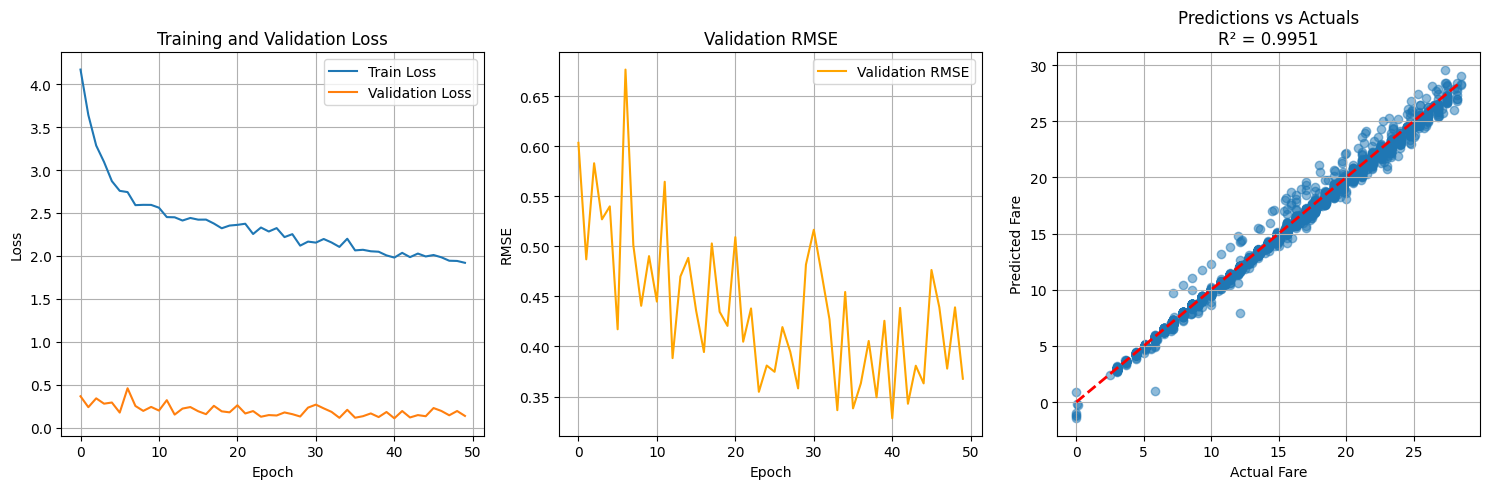


=== FINAL RESULTS ===
Final Test RMSE: $0.37
Final Test MAE: $0.23
Final R² Score: 0.9951


([4.16995100296916,
  3.6402260269591284,
  3.284998454304904,
  3.0936751473299804,
  2.8700556698555872,
  2.7571538145870442,
  2.7427302114581416,
  2.5906159665191684,
  2.5941698656125207,
  2.5935516900994706,
  2.560859099333227,
  2.451452731547991,
  2.4490381480608785,
  2.411476009855421,
  2.441271022803089,
  2.421579225875992,
  2.4222566301074577,
  2.376315553355163,
  2.3211750846953207,
  2.3527844478260582,
  2.3608868323922425,
  2.373942341411625,
  2.2543734083326354,
  2.3299666317537193,
  2.283432989572564,
  2.32320404133463,
  2.2184144593522994,
  2.252622349133072,
  2.118862211704254,
  2.1657932803001145,
  2.1541262106217327,
  2.1962565727212358,
  2.1554893263306627,
  2.1039721276905414,
  2.1993402981327566,
  2.0636572512224083,
  2.0705564603310407,
  2.0532076343994916,
  2.047859809334068,
  2.0052333463395424,
  1.979867962762949,
  2.0349015434762423,
  1.9848038792341074,
  2.026664446761861,
  1.992945856622864,
  2.0096746914542827,
  1.982

In [15]:
train_taxi_fare_model()

In [16]:
# Sample Input and Prediction Function
def predict_fare(model, sample_input, scaler=None):
    """
    Make a prediction for a single trip or batch of trips
    
    Args:
        model: Trained PyTorch model
        sample_input: Dictionary with feature values or numpy array
        scaler: StandardScaler used during training (if available)
    
    Returns:
        Predicted fare amount
    """
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        # If input is a dictionary, convert to array
        if isinstance(sample_input, dict):
            # Define the expected feature order (same as training)
            feature_order = ['PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 
                           'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 
                           'payment_type', 'trip_type', 'congestion_surcharge', 'cbd_congestion_fee', 
                           'trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_month']
            
            # Convert pickup_day to numeric if it's a string
            if 'pickup_day' in sample_input and isinstance(sample_input['pickup_day'], str):
                day_mapping = {
                    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
                    'Friday': 4, 'Saturday': 5, 'Sunday': 6
                }
                sample_input['pickup_day'] = day_mapping.get(sample_input['pickup_day'], 0)
            
            # Create array in correct order
            input_array = np.array([[sample_input[feature] for feature in feature_order]], dtype=np.float32)
        else:
            input_array = np.array(sample_input, dtype=np.float32)
            if input_array.ndim == 1:
                input_array = input_array.reshape(1, -1)
        
        # Apply scaling if scaler is provided
        if scaler is not None:
            input_array = scaler.transform(input_array)
        
        # Convert to tensor
        input_tensor = torch.tensor(input_array, dtype=torch.float32)
        
        # Make prediction
        prediction = model(input_tensor)
        
        # Return as float (remove tensor wrapper)
        return prediction.item() if prediction.numel() == 1 else prediction.numpy()

# Example 1: Using a dictionary input (most user-friendly)
print("=== SAMPLE PREDICTION EXAMPLES ===")

# Sample trip data
sample_trip = {
    'PULocationID': 161,      # Times Square area
    'DOLocationID': 230,      # Brooklyn
    'passenger_count': 1,
    'trip_distance': 8.5,     # miles
    'extra': 0.5,
    'mta_tax': 0.5,
    'tip_amount': 3.0,
    'tolls_amount': 0.0,
    'total_amount': 25.0,     # This would normally be calculated
    'payment_type': 1,        # Credit card
    'trip_type': 1,           # Street hail
    'congestion_surcharge': 2.5,
    'cbd_congestion_fee': 0.75,
    'trip_duration_minutes': 25,
    'pickup_hour': 14,        # 2 PM
    'pickup_day': 'Friday',   # Will be converted to 4
    'pickup_month': 1         # January
}

print("Sample trip details:")
for key, value in sample_trip.items():
    print(f"  {key}: {value}")

# Make prediction (you'll need to run this after training the model)
print("\n# To make a prediction, run:")
print("predicted_fare = predict_fare(model, sample_trip, train_dataset.scaler)")
print("print(f'Predicted fare: ${predicted_fare:.2f}')")

=== SAMPLE PREDICTION EXAMPLES ===
Sample trip details:
  PULocationID: 161
  DOLocationID: 230
  passenger_count: 1
  trip_distance: 8.5
  extra: 0.5
  mta_tax: 0.5
  tip_amount: 3.0
  tolls_amount: 0.0
  total_amount: 25.0
  payment_type: 1
  trip_type: 1
  congestion_surcharge: 2.5
  cbd_congestion_fee: 0.75
  trip_duration_minutes: 25
  pickup_hour: 14
  pickup_day: Friday
  pickup_month: 1

# To make a prediction, run:
predicted_fare = predict_fare(model, sample_trip, train_dataset.scaler)
print(f'Predicted fare: ${predicted_fare:.2f}')


In [17]:
# More Prediction Examples and Batch Processing
def create_sample_trips():
    """Create multiple sample trips for testing"""
    
    # Short trip - Manhattan to Manhattan
    short_trip = {
        'PULocationID': 161,      # Times Square
        'DOLocationID': 162,      # Near Times Square
        'passenger_count': 1,
        'trip_distance': 1.2,
        'extra': 0.0,
        'mta_tax': 0.5,
        'tip_amount': 1.5,
        'tolls_amount': 0.0,
        'total_amount': 8.5,
        'payment_type': 1,
        'trip_type': 1,
        'congestion_surcharge': 0.0,
        'cbd_congestion_fee': 0.0,
        'trip_duration_minutes': 8,
        'pickup_hour': 10,        # 10 AM
        'pickup_day': 'Tuesday',
        'pickup_month': 1
    }
    
    # Medium trip - Manhattan to Brooklyn
    medium_trip = {
        'PULocationID': 161,      # Times Square
        'DOLocationID': 36,       # Brooklyn Heights
        'passenger_count': 2,
        'trip_distance': 5.8,
        'extra': 0.5,
        'mta_tax': 0.5,
        'tip_amount': 4.0,
        'tolls_amount': 0.0,
        'total_amount': 22.0,
        'payment_type': 1,
        'trip_type': 1,
        'congestion_surcharge': 2.5,
        'cbd_congestion_fee': 0.75,
        'trip_duration_minutes': 18,
        'pickup_hour': 17,        # 5 PM rush hour
        'pickup_day': 'Friday',
        'pickup_month': 1
    }
    
    # Long trip - Manhattan to Queens
    long_trip = {
        'PULocationID': 161,      # Times Square
        'DOLocationID': 138,      # LaGuardia Airport area
        'passenger_count': 1,
        'trip_distance': 12.3,
        'extra': 1.0,
        'mta_tax': 0.5,
        'tip_amount': 6.0,
        'tolls_amount': 5.76,     # Bridge toll
        'total_amount': 45.0,
        'payment_type': 1,
        'trip_type': 1,
        'congestion_surcharge': 2.5,
        'cbd_congestion_fee': 0.75,
        'trip_duration_minutes': 35,
        'pickup_hour': 6,         # 6 AM
        'pickup_day': 'Monday',
        'pickup_month': 1
    }
    
    return [short_trip, medium_trip, long_trip]

def predict_multiple_fares(model, trip_list, scaler=None):
    """
    Predict fares for multiple trips
    """
    predictions = []
    trip_descriptions = ['Short trip', 'Medium trip', 'Long trip']
    
    print("=== MULTIPLE TRIP PREDICTIONS ===")
    
    for i, trip in enumerate(trip_list):
        predicted_fare = predict_fare(model, trip, scaler)
        predictions.append(predicted_fare)
        
        print(f"\n{trip_descriptions[i]}:")
        print(f"  Distance: {trip['trip_distance']} miles")
        print(f"  Duration: {trip['trip_duration_minutes']} minutes") 
        print(f"  Time: {trip['pickup_hour']}:00 on {trip['pickup_day']}")
        print(f"  Passengers: {trip['passenger_count']}")
        print(f"  🎯 Predicted Fare: ${predicted_fare:.2f}")
    
    return predictions

# Interactive prediction function
def interactive_prediction(model, scaler=None):
    """
    Interactive function to input trip details and get prediction
    """
    print("=== INTERACTIVE FARE PREDICTION ===")
    print("Enter trip details:")
    
    try:
        trip = {}
        trip['PULocationID'] = float(input("Pickup Location ID (e.g., 161 for Times Square): ") or 161)
        trip['DOLocationID'] = float(input("Dropoff Location ID (e.g., 230 for Brooklyn): ") or 230)
        trip['passenger_count'] = float(input("Number of passengers (1-6): ") or 1)
        trip['trip_distance'] = float(input("Trip distance in miles (e.g., 5.2): ") or 5.0)
        trip['extra'] = float(input("Extra charges (e.g., 0.5): ") or 0.5)
        trip['mta_tax'] = float(input("MTA tax (usually 0.5): ") or 0.5)
        trip['tip_amount'] = float(input("Expected tip amount: ") or 2.0)
        trip['tolls_amount'] = float(input("Toll charges: ") or 0.0)
        trip['total_amount'] = float(input("Estimated total (for model input): ") or 20.0)
        trip['payment_type'] = float(input("Payment type (1=Credit, 2=Cash): ") or 1)
        trip['trip_type'] = float(input("Trip type (1=Street hail, 2=Dispatch): ") or 1)
        trip['congestion_surcharge'] = float(input("Congestion surcharge: ") or 2.5)
        trip['cbd_congestion_fee'] = float(input("CBD congestion fee: ") or 0.75)
        trip['trip_duration_minutes'] = float(input("Trip duration in minutes: ") or 20)
        trip['pickup_hour'] = float(input("Pickup hour (0-23): ") or 14)
        trip['pickup_day'] = input("Pickup day (Monday-Sunday): ") or "Friday"
        trip['pickup_month'] = float(input("Pickup month (1-12): ") or 1)
        
        predicted_fare = predict_fare(model, trip, scaler)
        print(f"\n🚖 Predicted Fare: ${predicted_fare:.2f}")
        
    except ValueError:
        print("Invalid input. Please enter numeric values where required.")
    except Exception as e:
        print(f"Error: {e}")

print("Prediction functions ready!")
print("\nUsage examples:")
print("1. predict_fare(model, sample_trip, train_dataset.scaler)")
print("2. sample_trips = create_sample_trips()")
print("   predict_multiple_fares(model, sample_trips, train_dataset.scaler)")
print("3. interactive_prediction(model, train_dataset.scaler)")

Prediction functions ready!

Usage examples:
1. predict_fare(model, sample_trip, train_dataset.scaler)
2. sample_trips = create_sample_trips()
   predict_multiple_fares(model, sample_trips, train_dataset.scaler)
3. interactive_prediction(model, train_dataset.scaler)


In [18]:
# Complete Usage Example
def demo_predictions():
    """
    Complete demonstration of how to use the model for predictions
    """
    print("=== COMPLETE PREDICTION DEMO ===")
    
    # Check if model is trained
    try:
        # Test if model exists and is trained
        model.eval()
        print("✅ Model is ready for predictions!")
        
        # Get the scaler from training dataset
        scaler = train_dataset.scaler
        print("✅ Scaler retrieved from training dataset")
        
        print("\n" + "="*60)
        print("EXAMPLE 1: Single Trip Prediction")
        print("="*60)
        
        # Simple example
        example_trip = {
            'PULocationID': 161,     # Times Square
            'DOLocationID': 230,     # Brooklyn
            'passenger_count': 2,
            'trip_distance': 6.5,
            'extra': 0.5,
            'mta_tax': 0.5,
            'tip_amount': 3.5,
            'tolls_amount': 0.0,
            'total_amount': 28.0,
            'payment_type': 1,
            'trip_type': 1,
            'congestion_surcharge': 2.5,
            'cbd_congestion_fee': 0.75,
            'trip_duration_minutes': 22,
            'pickup_hour': 15,       # 3 PM
            'pickup_day': 'Wednesday',
            'pickup_month': 1
        }
        
        predicted_fare = predict_fare(model, example_trip, scaler)
        print(f"🚖 Trip from Times Square to Brooklyn")
        print(f"   Distance: {example_trip['trip_distance']} miles")
        print(f"   Duration: {example_trip['trip_duration_minutes']} minutes")
        print(f"   Passengers: {example_trip['passenger_count']}")
        print(f"   Predicted Fare: ${predicted_fare:.2f}")
        
        print("\n" + "="*60)
        print("EXAMPLE 2: Multiple Trip Predictions")
        print("="*60)
        
        # Multiple trips
        sample_trips = create_sample_trips()
        predictions = predict_multiple_fares(model, sample_trips, scaler)
        
        print("\n" + "="*60)
        print("EXAMPLE 3: Quick Manual Input")
        print("="*60)
        
        # Array-based input (if you know the exact feature order)
        # Order: PULocationID, DOLocationID, passenger_count, trip_distance, extra, mta_tax, 
        #        tip_amount, tolls_amount, total_amount, payment_type, trip_type, 
        #        congestion_surcharge, cbd_congestion_fee, trip_duration_minutes, 
        #        pickup_hour, pickup_day, pickup_month
        
        manual_input = [74, 75, 1, 3.2, 0.0, 0.5, 1.8, 0.0, 12.5, 1, 1, 0.0, 0.0, 12, 9, 1, 1]
        
        predicted_fare_manual = predict_fare(model, manual_input, scaler)
        print(f"Manual array input prediction: ${predicted_fare_manual:.2f}")
        
        print("\n✅ All prediction examples completed successfully!")
        
    except NameError:
        print("❌ Model not found. Please train the model first by running:")
        print("   train_taxi_fare_model()")
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure the model is trained and datasets are created.")

print("Demo function ready!")
print("\nTo run a complete demonstration:")
print("demo_predictions()")

print("\n" + "="*60)
print("QUICK REFERENCE - How to make predictions:")
print("="*60)
print("1. After training: demo_predictions()")
print("2. Single trip:    predict_fare(model, trip_dict, train_dataset.scaler)")  
print("3. Multiple trips: predict_multiple_fares(model, trip_list, train_dataset.scaler)")
print("4. Interactive:    interactive_prediction(model, train_dataset.scaler)")
print("="*60)

Demo function ready!

To run a complete demonstration:
demo_predictions()

QUICK REFERENCE - How to make predictions:
1. After training: demo_predictions()
2. Single trip:    predict_fare(model, trip_dict, train_dataset.scaler)
3. Multiple trips: predict_multiple_fares(model, trip_list, train_dataset.scaler)
4. Interactive:    interactive_prediction(model, train_dataset.scaler)


In [19]:
sample_trip = {
    'PULocationID': 161,      # Times Square
    'DOLocationID': 230,      # Brooklyn  
    'passenger_count': 2,
    'trip_distance': 6.5,
    'extra': 0.5,
    'mta_tax': 0.5,
    'tip_amount': 3.5,
    'tolls_amount': 0.0,
    'total_amount': 28.0,
    'payment_type': 1,
    'trip_type': 1,
    'congestion_surcharge': 2.5,
    'cbd_congestion_fee': 0.75,
    'trip_duration_minutes': 22,
    'pickup_hour': 15,        # 3 PM
    'pickup_day': 'Wednesday',
    'pickup_month': 1
}

# Get prediction
predicted_fare = predict_fare(model, sample_trip, train_dataset.scaler)
print(f"Predicted fare: ${predicted_fare:.2f}")

Predicted fare: $19.29
